In [101]:
import os
os.chdir('../quafing/')
print(f"Working directory: {os.getcwd()}")

import quafing as q


import random
import numpy as np
from scipy.stats import mode

from sklearn.feature_selection import mutual_info_regression

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt


plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15, 
                     "figure.dpi" : 100, 
                     "legend.fontsize" : 13, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True, 
                     "figure.figsize":(6, 5)})

Working directory: /Users/charlesdupont/Desktop/Thesis/code/quafing


In [2]:
def load_data(path):
    """
    Loads .dta file using provided path.
    """
    return pd.read_stata(path, convert_categoricals=False)


def add_missing_hhids(df):
    """
    Adds empty rows for hhids missing from df.
    df must already have an "hhid" column!
    """
    df = df.round({"hhid":1})
    missing = set(UNIQUE_HHID) - set(df["hhid"].unique())
    missing_dict = {"hhid":[round(item, 1) for item in list(missing)]}
    for col in df.columns:
        if col != "hhid":
            missing_dict[col] = [np.nan]*len(missing)
    missing_df = pd.DataFrame.from_dict(missing_dict)
    concat = pd.concat([df, missing_df])
    return concat.round({"hhid":1})


def column_selection(df, keep=None, remove=None):
    """
    Performs column selection on dataframe.
    Args:
        no_change: boolean indicating whether to keep all columns
        keep: list of columns to keep
        remove: list of columns to remove
    Returns:
        updated dataframe
    """
    if keep:
        return df[keep]
    elif remove:
        return df.loc[:, ~df.columns.isin(remove)]
    else:
        return df


def get_processed_df(results):
    processed = pd.DataFrame.from_dict({})
    for column in results[1]:
        processed[column] = [results[hhid][column] for hhid in results]
    return processed


def apply_mapping(df, mapping):
    results = {hhid:{"hhid":hhid} for hhid in UNIQUE_HHID}
    for hhid in UNIQUE_HHID:
        household = df.loc[df.hhid==hhid]    
        for label, tup in mapping.items():
            col, operation = tup
            non_nan = household.loc[~household[col].isna()]
            results[hhid][label] = operation_lambda[operation](non_nan[col]) if len(non_nan) else np.nan

    return get_processed_df(results) 

In [3]:
DATA_DIR    = "../../BCCASII/"
DATA_SUBDIR = "Household/"

In [4]:
PROCESSED_DFS  = []
ADAPTATION_DFS = []

In [5]:
operation_lambda = {
    "sum": lambda x: x.sum(),
    "min": lambda x: x.min(),
    "max": lambda x: x.max(),
    "mean": lambda x: round(x.mean()),
    "mode": lambda x: x.mode()[0]
}

## A: Location and identification detail

In [6]:
filename = "001_mod_a.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [7]:
# keep household ID, agro-ecological zone
processed = column_selection(df, keep=["hhid", "ezcode"])

# construct community code from union, thana, district codes
processed["community_code"] = df["ucode"].astype(str) + "_" + \
                              df["tcode"].astype(str) + "_" + \
                              df["dcode"].astype(str)

UNIQUE_HHID = np.round(df["hhid"].unique().astype(np.float64), 1)
processed["hhid"] = processed["hhid"].astype(np.float64)

In [8]:
PROCESSED_DFS.append(processed)

## B: Household composition and education

In [9]:
filename = "002_mod_b.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [10]:
education_ordering = [99, 66, 67, 68, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 22, 10, 33, 12, 15, 16, 17]
literacy_ordering  = [1, 2, 3, 4]

results = {hhid:{} for hhid in UNIQUE_HHID}
for hhid in UNIQUE_HHID:
    household = df.loc[df.hhid==hhid]    
    L = len(household)
    if L == 0:
        results[hhid] = {
            "hhid": hhid,
            "household_size": np.nan,
            "ratio_male": np.nan,
            "ratio_female": np.nan,
            "num_children": np.nan,
            "highest_education": np.nan,
            "highest_literacy": np.nan
        }
        continue

    results[hhid]["hhid"] = hhid

    # household size
    results[hhid]["household_size"] = L
    
    # ratio male, female
    m = sum(household["b01"]==1)
    f = sum(household["b01"]==2)
    results[hhid]["ratio_male"]   = m/L
    results[hhid]["ratio_female"] = f/L
    
    # number of children
    results[hhid]["num_children"] = sum(household["b03"] < 18)
    
    # highest level of education
    education_levels = [education_ordering.index(x)
                        for x in [x for x in list(household["b06"]) if not np.isnan(x)]]
    results[hhid]["highest_education"] = max(education_levels) if len(education_levels) else np.nan
        
    # highest level of literacy
    literacy_labels = [literacy_ordering.index(x)
                       for x in [x for x in list(household["b05"]) if not np.isnan(x)]]
    results[hhid]["highest_literacy"] = max(literacy_labels) if len(literacy_labels) else np.nan

processed = get_processed_df(results)


# primary occupation categories
# categories = {
#     "day_labor": [1,2,3],
#     "self_employ_farm": [4,5,6,7,8],
#     "self_employ_non_farm": [9],
#     "low_income_profession": [10,11,12,13],
#     "mechanic": [14,15],
#     "other": [16, 17, 18, 19],
#     "non_earning": [20,21,22,23,24,25,26]
# }

# for c, c_list in categories.items():
#     c_dict = {hhid:0 for hhid in unique_hhids}
#     for hhid in unique_hhids:
#         household = df.loc[df.hhid==hhid]
#         primary_occupation_labels = list(household["b08_1"])
#         for item in c_list:
#             if item in primary_occupation_labels:
#                 c_dict[hhid] += 1
#     processed = processed.join(pd.DataFrame.from_dict({c:c_dict}))

In [11]:
PROCESSED_DFS.append(processed)

## C: Roster of land and water bodies owned or under operation

In [12]:
filename = "003_mod_c.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [13]:
mapping = {
    "total_land_value_per_month": ("c113", "sum"),
    "min_land_acquisition_year": ("c111", "min"),
    "max_land_acquisition_year": ("c111", "max"),
    "mean_land_acquisition_year": ("c111", "mean"),
    "plot_type": ("c101", "mode"),
    "soil_type": ("c105", "mode"),
    "land_operational_status": ("c107", "mode"),
    "land_acquisition_means": ("c110", "mode")
}

processed = apply_mapping(df, mapping)

In [14]:
PROCESSED_DFS.append(processed)

## F1: Livestock and poultry

In [15]:
filename = "004_mod_f1.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [16]:
# # household id
# processed = pd.DataFrame.from_dict({"hhid":list(unique_hhids)})

# categories = {
#     "cattle_buffalo":1,
#     "goat_sheep":2,
#     "pigs":3,
#     "chidken_duck":4
# }

# cols = [("count_2011", "f102"), ("value_2011", "f103"), 
#         ("count_now", "f104"), ("value_now", "f105"), ("total_selling_value", "f117")]   

# results = {hhid:{} for hhid in unique_hhids}
# for hhid in unique_hhids:
#     household = df.loc[df.hhid==hhid]
#     for c, number in categories.items():
#         if number not in list(household["f101"]):
#             # TODO: handle missing value!
#             for l, _ in cols:
#                 results[hhid][c+"_"+l] = np.nan
#         else:
#             for l, col in cols:
#                 value = household.loc[household["f101"]==number][col].iloc[0]
#                 # TODO: handle missing value here!
#                 if np.isnan(value):
#                     results[hhid][c+"_"+l] = np.nan
#                 else:
#                     results[hhid][c+"_"+l] = value
                    
# for column in results[1]:
#     processed[column] = [results[hhid][column] for hhid in results]

In [17]:
mapping = {
    "count_2011": ("f102", "sum"),
    "value_2011": ("f103", "sum"),
    "count_now": ("f104", "sum"),
    "value_now": ("f105", "sum"),
    "total_selling_value": ("f117", "sum"),
}

processed = apply_mapping(df, mapping)

In [18]:
PROCESSED_DFS.append(processed)

## F3: Expenditure for livestock, Poultry/Duckery Production Last 12 Months

In [19]:
filename = "005_mod_f3.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [20]:
mapping = {
    "livestock_fodder_value": ("f302", "sum"),
    "livestock_medication_value": ("f303", "sum"),
    "livestock_hired_male_labor": ("f306_1", "sum"),
}

processed = apply_mapping(df, mapping)

In [21]:
PROCESSED_DFS.append(processed)

## G1: Credit obtained

In [22]:
filename = "006_mod_g.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [23]:
mapping = {
    "credit_cash_borrowed": ("g07", "sum"),
    "credit_value_borrowed": ("g10", "sum"),
    "credit_cash_repaid": ("g16", "sum"),
    "credit_value_repaid": ("g18", "sum")
}

processed = apply_mapping(df, mapping)

In [24]:
PROCESSED_DFS.append(processed)

## G2: Repayment and utilization of Loan

In [25]:
# TODO

## H: Household Assets

In [26]:
filename = "007_mod_h.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [27]:
# total value per household asset category
categories = {
    "value_consumable_durables":[i for i in range(1, 12)],
    "value_transport":[i for i in range(12, 16)],
    "value_livestock_poultry":[i for i in range(16, 20)],
    "value_agricultural_equipments":[i for i in range(20,29)],
    "value_other":[29]
}

results = {hhid:{"hhid":hhid} for hhid in UNIQUE_HHID}
for hhid in UNIQUE_HHID:
    household = df.loc[df.hhid==hhid]
    for c in categories:
        category_assets = household.loc[household["asset"].isin(categories[c])]
        results[hhid][c] = category_assets["h06"].sum() if len(category_assets) else np.nan

processed = get_processed_df(results)

In [28]:
PROCESSED_DFS.append(processed)

## H1: Assets: Sales of Assets and Change in Ownership

In [29]:
filename = "008_mod_h1.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [30]:
mapping = {"sale_of_assets_value": ("h108", "sum")}
processed = apply_mapping(df, mapping)

In [31]:
PROCESSED_DFS.append(processed)

## I: Food Consumption: Purchases, Home Production, and Other Sources

In [32]:
filename = "009_mod_i.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [33]:
food_categories = {
    "food_cereals":np.arange(1,10),
    "food_pulses":np.arange(11,18),
    "food_edible_oil":np.arange(21,25),
    "food_vegetables":np.arange(31,56),
    "food_leafy_vegetables":np.arange(61,75),
    "food_meat_eggs_milk":np.arange(81,88),
    "food_fruits":np.arange(91,113),
    "food_fish_large":np.arange(121,132),
    "food_fish_small":np.arange(141,149),
    "food_spices":np.arange(151,161),
    "food_other":np.arange(171,177),
    "food_drinks":np.arange(181,184),
    "food_other_outside_home":np.arange(201,213)
}

results = {hhid:{"hhid":hhid} for hhid in UNIQUE_HHID}
for hhid in UNIQUE_HHID:
    household = df.loc[df.hhid==hhid]
    for c, fcodes in food_categories.items():
        relevant_rows = household.loc[household["fcode"].isin(fcodes)]
        for (col, label) in [("i07", "value_"), ("i04", "weight_")]:
            non_nan = relevant_rows.loc[~relevant_rows[col].isna()]
            results[hhid][label+c] = non_nan[col].sum() if len(non_nan) else np.nan
            
processed = get_processed_df(results)

In [34]:
PROCESSED_DFS.append(processed)

## J1, J2: Non-food Expenditure

In [35]:
filename = "010_mod_j.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [36]:
non_food_categories = {
    "rent_expenses":[1,2],
    "fuel_expenses":[3,4,5,6],
    "local_transport_expenses":[7,8],
    "miscellaneous_expenses":[9,10,11,12,13,29,30,31,32,54,55],
    "health_expenses":[14,15,16],
    "communication_expenses":[17,18],
    "personal_items_expenses":np.arange(19,25),
    "entertainment_expenses":[25,26],
    "non_local_travel_expenses":[27,28],
    "clothing_expenses":np.arange(33,39),
    "furniture_household_expenses":np.arange(39,49),
    "utilities_taxes_fees":np.arange(49,54),
    "family_events_expenses":[56,57],
    "wedding_costs_bride":np.arange(59,63),
    "wedding_costs_groom":np.arange(63,67),
    "education_expenses":np.arange(67,73),
    "vehicle_expenses":np.arange(73,77)
}

results = {hhid:{"hhid":hhid} for hhid in UNIQUE_HHID}
for hhid in UNIQUE_HHID:
    household = df.loc[df.hhid==hhid]
    for c, nfcodes in non_food_categories.items():
        relevant_rows = household.loc[household["nfcode"].isin(nfcodes)]
        for col in ["j02_1", "j02_2", "j03_1", "j03_2"]:
            non_nan = relevant_rows.loc[~relevant_rows[col].isna()]
            results[hhid][col+"_"+c] = non_nan[col].sum() if len(non_nan) else np.nan

processed = get_processed_df(results)

In [37]:
PROCESSED_DFS.append(processed)

## K: Housing, Source of Water and sanitation

In [38]:
filename = "011_mod_k.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [39]:
processed = column_selection(df, keep=["hhid", "k01", "k02", "k03", "k03_1",
                                       "k04", "k05", "k05_1", "k06", "k07", "k10"])

In [40]:
PROCESSED_DFS.append(processed)

## L : Weather events adversely affected the household or the farming

In [41]:
filename = "012_mod_l.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [42]:
calamity_numbers = [i for i in range(1, 13)]

results = {hhid:{"hhid":hhid} for hhid in UNIQUE_HHID}
for hhid in UNIQUE_HHID:
    household = df.loc[df.hhid == hhid]
    nums = list(household["l01"])
    for n in calamity_numbers:
        if n not in nums:
            results[hhid]["calamity_"+str(n)] = np.nan
        else:
            results[hhid]["calamity_"+str(n)] = 1 if int(household.loc[household["l01"]==n]["l02"]) == 1 else 0

processed = get_processed_df(results)                

In [43]:
PROCESSED_DFS.append(processed)

## L1: Weather events adversely affected the household or the farming cope

In [44]:
filename = "013_mod_l1.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

mapping   = {"weather_events_damage": ("l1_05", "sum")}
processed = apply_mapping(df, mapping)
PROCESSED_DFS.append(processed)

## L2: Shocks

In [45]:
filename = "014_mod_l2.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

mapping   = {"shocks_loss_value": ("l2_06", "sum")}
processed = apply_mapping(df, mapping)
PROCESSED_DFS.append(processed)

## L3: Positive Economic Events

In [46]:
filename = "015_mod_l3.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

mapping   = {"positive_events_value": ("l3_06", "sum")}
processed = apply_mapping(df, mapping)
PROCESSED_DFS.append(processed)

## M: Agricultural extension

In [47]:
filename = "017_mod_m.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

PROCESSED_DFS.append(df)

## Q: Perceptions of Climate Change

In [48]:
filename = "018_mod_q.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

PROCESSED_DFS.append(df)

## O: Changes in farming practices due to climate change

In [49]:
filename = "019_mod_o.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [50]:
keep = ["hhid"] + ["o0"+str(i)+"_1" for i in range(2, 9)] + ["o09"] + \
       ["o"+str(i) for i in range(10, 23)] + ["o"+str(i)+"_1" for i in range(23, 29)] + ["o29"]

processed = column_selection(df, keep=keep)
PROCESSED_DFS.append(processed)

In [51]:
ADAPTATION_DFS.append(processed)

## O1: Any integration about Livestock/Poultry

In [52]:
filename = "020_mod_o1.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [53]:
keep = ["hhid"] + ["o1_01_"+str(i) for i in range(1, 10)]
processed = column_selection(df, keep=keep)

In [54]:
PROCESSED_DFS.append(processed)

In [55]:
ADAPTATION_DFS.append(processed)

## O2: Constraints to adaptation

In [56]:
filename = "021_mod_o2.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [57]:
max_len = 0
for hhid in UNIQUE_HHID:
    max_len = max(max_len, len(df.loc[df.hhid==hhid]))

results = {hhid:{"hhid":hhid} for hhid in UNIQUE_HHID}
for hhid in UNIQUE_HHID:
    household = df.loc[df.hhid==hhid]
    idx = 0
    for _, row in household.iterrows():
        results[hhid][f"constraints_{idx}_measure"] = row["o2_01"]
        severity = [x for x in row[["o2_03_1", "o2_03_2", "o2_03_3", "o2_03_4", "o2_03_5"]] if not np.isnan(x)]
        if len(severity):
            for i in range(5):
                if i in severity:
                    most_severe = severity.index(i) + 1
                    results[hhid][f"constraints_{idx}_constraint"] = row[f'o2_02_{most_severe}']
                    break
        else:
            results[hhid][f"constraints_{idx}_constraint"] = np.nan
        
        idx += 1
    
    while idx < max_len:
        results[hhid][f"constraints_{idx}_measure"] = np.nan
        results[hhid][f"constraints_{idx}_constraint"] = np.nan
        idx += 1
        
processed = get_processed_df(results)

In [58]:
PROCESSED_DFS.append(processed)

## R1: Information of group based approach

In [59]:
filename = "022_mod_r1.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [60]:
groups = np.arange(1, 19)

results = {hhid:{"hhid":hhid} for hhid in UNIQUE_HHID}
for hhid in UNIQUE_HHID:
    household = df.loc[df.hhid==hhid]
    for g in groups:
        g_row = household.loc[household["r1_01"]==g]        
        if len(g_row):
            membership_values = list(g_row["r1_02"])
            results[hhid][f"group_{g}_membership"] = int(1 in membership_values)
        else:
            results[hhid][f"group_{g}_membership"] = np.nan
            
processed = get_processed_df(results)

In [61]:
PROCESSED_DFS.append(processed)

## R2: Group activity related information

In [62]:
filename = "023_mod_r2.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [63]:
# a few duplicate rows found in this data file...
duplicates = []
for hhid in df["hhid"].unique():
    if len(df.loc[df.hhid==hhid]) > 1:
        duplicates.append(hhid)
    
drop_indices = []
for d in duplicates:
    drop_indices.append(list(df.loc[df.hhid==d].index)[0])

df = df.drop(drop_indices)

In [64]:
keep = ["hhid"] + [f"r2_15_{i}" for i in range(1,5)] + [f"r2_16_{i}" for i in range(1,5)]
for j in range(17, 24):
    keep += [f"r2_{j}_{i}_1" for i in range(1,5)]
    
processed = column_selection(df, keep=keep)
PROCESSED_DFS.append(processed)

## R3: Network

In [65]:
filename = "024_mod_r3.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [66]:
processed = column_selection(df, remove=["r3_01_1", "r3_01_2"])

In [67]:
PROCESSED_DFS.append(processed)

## R4: Trust and Solidarity

In [68]:
filename = "025_mod_r4.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [69]:
processed = column_selection(df, remove=["r4_01_1", "r4_01_2"])

In [70]:
PROCESSED_DFS.append(processed)

## R5: Economic setbacks

In [71]:
filename = "026_mod_r5.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [72]:
results = {hhid:{"hhid":hhid} for hhid in UNIQUE_HHID}
for hhid in UNIQUE_HHID:
    household = df.loc[df.hhid==hhid]
    results[hhid]["serious_economic_setback"] = 1 if 1 in list(household["r5"]) else 0
    
processed = get_processed_df(results)

In [73]:
PROCESSED_DFS.append(processed)

## R6: Collective Action and Cooperation and Sociability

In [74]:
filename = "027_mod_r6.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [75]:
processed = column_selection(df, remove=["r6_01_1", "r6_01_2"])

In [76]:
PROCESSED_DFS.append(processed)

## R7: Information and Communication

In [77]:
filename = "028_mod_r7.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [78]:
processed = column_selection(df, remove=["r7_01_1", "r7_01_2"])

In [79]:
PROCESSED_DFS.append(processed)

## R8: Production and climate Information

In [80]:
filename = "029_mod_r8.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [81]:
keep = ["hhid", "r8_02_1", "r8_02_2", "r8_06_1", "r8_06_2", "r8_14_1", "r8_14_2"]
processed = column_selection(df, keep=keep)

In [82]:
PROCESSED_DFS.append(processed)

## R9: Production and climate Information

In [83]:
filename = "030_mod_r9.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [84]:
keep = ["hhid", "r9_02_1", "r9_02_2", "r9_09_1", "r9_09_2"]
processed = column_selection(df, keep=keep)

In [85]:
PROCESSED_DFS.append(processed)

## S: Empowerment and Political Action

In [86]:
filename = "031_mod_s.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [87]:
processed = column_selection(df, remove=["s_01_1", "s_01_2"])

In [88]:
PROCESSED_DFS.append(processed)

## T: Employment

In [89]:
filename = "032_mod_t.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [90]:
job_categories = {
    "job_wage_labor":np.arange(1,12),
    "job_salaried_worker":np.arange(12,22),
    "job_self_employment":np.arange(22,48),
    "job_trader":np.arange(50,55),
    "job_production":np.arange(55,58),
    "job_livestock_poultry_service":np.arange(58,64),
    "job_farming":np.arange(64,73)
}

results = {hhid:{"hhid":hhid} for hhid in UNIQUE_HHID}
for hhid in UNIQUE_HHID:
    household = df.loc[df.hhid==hhid]
    relevant = list(household["t05"])
    for c, numbers in job_categories.items():
        results[hhid][c] = 0
        for n in numbers:
            if n in relevant:
                results[hhid][c] += 1
            
processed = get_processed_df(results)

In [91]:
PROCESSED_DFS.append(processed)

## U: Time use of male and female members in the household

In [92]:
# TODO: discard?

## V: Anthropometry

In [93]:
# TODO: discard?

# Combine processed dataframes

In [94]:
# mind the treatment of MISSING VALUES!
    # do we really want to impute "0" when no information is present?
    # just leave as empty
        # then if we see a household with many empty fields, or a feature with mostly empty values,
        # we remove it

In [96]:
# add missing household ids
all_hhids_present = []
for idx, df in enumerate(PROCESSED_DFS):
    df["hhid"] = np.round(df["hhid"].astype(np.float64), 1)
    if len(df["hhid"].unique()) != len(UNIQUE_HHID):
        all_hhids_present.append(add_missing_hhids(df))
    else:
        all_hhids_present.append(df)

# sanity check
for df in all_hhids_present:
    hids = df["hhid"].unique()
    for h in hids:
        assert h in UNIQUE_HHID
    for h in UNIQUE_HHID:
        assert h in hids
        
# merge all dataframes
df = all_hhids_present[0]
for df1 in all_hhids_present[1:]:
    df = df.merge(df1, on="hhid", how="inner")
assert df.shape[0] == len(UNIQUE_HHID)

In [113]:
df.to_csv(DATA_DIR + DATA_SUBDIR + "combined.csv")
df

,hhid,ezcode,community_code,household_size,ratio_male,ratio_female,num_children,highest_education,highest_literacy,total_land_value_per_month,...,s_07_2,s_08_2,s_09_2,job_wage_labor,job_salaried_worker,job_self_employment,job_trader,job_production,job_livestock_poultry_service,job_farming
0,1.0,7,1_1_1,9.0,0.555556,0.444444,3.0,20.0,3.0,50.0,...,1.0,1.0,2.0,0,1,1,0,0,0,3
1,2.0,7,1_1_1,6.0,0.500000,0.500000,1.0,8.0,3.0,500.0,...,1.0,1.0,3.0,1,0,0,0,0,0,3
2,3.0,7,1_1_1,4.0,0.750000,0.250000,2.0,18.0,3.0,NaN,...,2.0,1.0,3.0,0,0,1,0,0,0,3
3,4.0,7,1_1_1,6.0,0.333333,0.666667,1.0,8.0,3.0,384.0,...,1.0,1.0,3.0,0,0,0,0,0,0,4
4,5.0,7,1_1_1,7.0,0.428571,0.571429,1.0,15.0,3.0,NaN,...,1.0,1.0,3.0,0,0,1,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,796.0,6,40_39_31,10.0,0.400000,0.600000,2.0,12.0,3.0,NaN,...,1.0,1.0,3.0,0,0,1,0,0,0,3
823,797.0,6,40_39_31,9.0,0.333333,0.666667,4.0,13.0,3.0,510.0,...,2.0,2.0,2.0,1,0,0,0,0,0,4
824,798.0,6,40_39_31,7.0,0.571429,0.428571,1.0,9.0,3.0,NaN,...,1.0,1.0,2.0,0,0,0,0,0,0,2
825,799.0,6,40_39_31,9.0,0.555556,0.444444,4.0,17.0,3.0,NaN,...,1.0,1.0,2.0,0,0,0,0,0,0,3


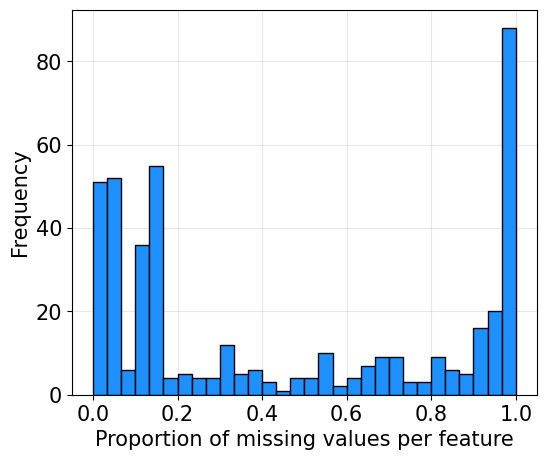

In [104]:
col_nan_counts = {}
L = len(df)
for col in df.columns:
    col_nan_counts[col] = (df[col].isna().sum()) / L

plt.hist(col_nan_counts.values(), color="dodgerblue", edgecolor="k", bins=30)
plt.xlabel("Proportion of missing values per feature")
plt.ylabel("Frequency")
plt.show()

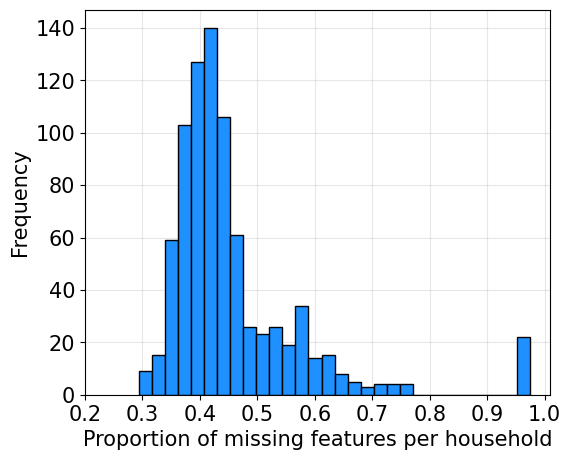

In [150]:
row_nan_counts = {}
num_cols = len(df.columns)
for i in range(len(df)):
    row = df.loc[[i]]
    hhid = list(row["hhid"])[0]
    row_nan_counts[hhid] = (row.isna().sum().sum()) / num_cols

plt.hist(row_nan_counts.values(), color="dodgerblue", edgecolor="k", bins=30)
plt.xticks(np.linspace(0.2, 1.0, 9))
plt.xlabel("Proportion of missing features per household")
plt.ylabel("Frequency")
plt.show()

# Mutual Information Regression

In [219]:
# compute number of changes implemented by each household
num_changes = {hhid:0 for hhid in UNIQUE_HHID}
for DF in ADAPTATION_DFS:
    for hhid in UNIQUE_HHID:
        hh = DF.loc[DF.hhid==hhid]
        if len(hh):
            ignore_hhid_col = hh.loc[:, ~hh.columns.isin(['hhid'])]
            num_changes[hhid] += sum(np.array(ignore_hhid_col.iloc[0]==1))

### With NaN filling

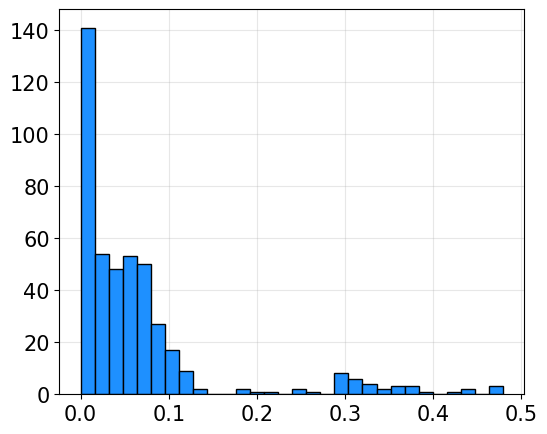

In [220]:
adaptation_target = np.array(list(num_changes.values()))
features = column_selection(df, remove=["hhid", "community_code"]).fillna(-1) # replace nan with -1
mutual_information_scores = mutual_info_regression(features, adaptation_target, 
                                                   discrete_features="auto") # TODO: pass array for discreteness

plt.hist(mutual_information_scores, color="dodgerblue", edgecolor="k", bins=30)
plt.show()

In [221]:
feature_cols = list(features.columns)
d = {feature_cols[i]:mutual_information_scores[i] for i in range(len(feature_cols))}

ordered = sorted([(k,v) for (k,v) in d.items()], key = lambda x: d[x[0]], reverse=True)
ordered_no_target = [item for item in ordered if item[0][0] != "o"]
ordered_no_target

[('constraints_0_measure', 0.39234847596922817),
 ('constraints_1_measure', 0.36853737343821225),
 ('constraints_0_constraint', 0.32058561860297896),
 ('constraints_1_constraint', 0.3080571952654303),
 ('constraints_2_measure', 0.29782633720301943),
 ('constraints_3_measure', 0.266331288285262),
 ('constraints_3_constraint', 0.2454091388110271),
 ('constraints_2_constraint', 0.24355883612697804),
 ('m01', 0.14373220437827605),
 ('constraints_4_measure', 0.13864792807058102),
 ('m07', 0.12579682932278358),
 ('constraints_4_constraint', 0.11925723627805018),
 ('r2_23_1_1', 0.11870037413922807),
 ('r7_05_1', 0.1152410933523993),
 ('r2_19_1_1', 0.11374209780287314),
 ('r2_20_1_1', 0.11229289643311446),
 ('q01_1', 0.11203428443851493),
 ('job_farming', 0.11201958095322428),
 ('r2_22_1_1', 0.1078409918755221),
 ('ezcode', 0.10745105886660422),
 ('q07_1', 0.10677899517784839),
 ('r2_16_1', 0.10535984949667032),
 ('q04', 0.10221914999656478),
 ('k07', 0.1016104616127147),
 ('q03', 0.1013665934

### Without NaN filling

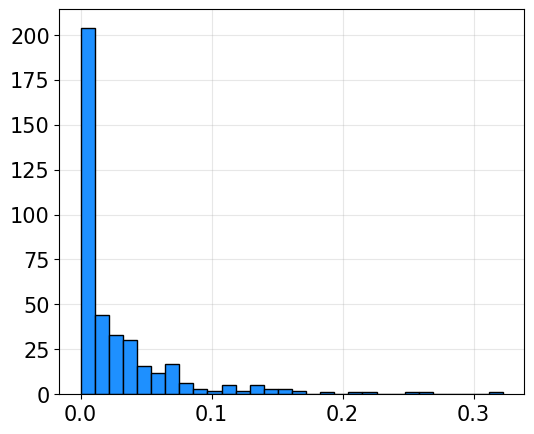

In [251]:
mi_scores = {}
for col in df.columns:
    if col not in ["hhid", "community_code"]:
        non_nan_rows = df.loc[~df[col].isna()]
        if len(non_nan_rows) < 5:
            continue
        indices = np.array(non_nan_rows.index)
        targets = adaptation_target[indices]
        mi_scores[col] = mutual_info_regression(np.array(list(non_nan_rows[col])).reshape(-1,1), targets)[0]
        
plt.hist(mi_scores.values(), color="dodgerblue", edgecolor="k", bins=30)
plt.show()

In [252]:
ordered = sorted([(k,v) for (k,v) in mi_scores.items()], key = lambda x: mi_scores[x[0]], reverse=True)
ordered_no_target = [item for item in ordered if item[0][0] != "o"]
ordered_no_target

[('constraints_0_measure', 0.3227410581457395),
 ('j03_2_miscellaneous_expenses', 0.26760704895379805),
 ('r6_04_2_2', 0.25503878319387185),
 ('j02_1_vehicle_expenses', 0.21901586068252743),
 ('r6_03_1_3', 0.161238297063393),
 ('constraints_1_measure', 0.15756197334061683),
 ('constraints_6_constraint', 0.1426777786159914),
 ('constraints_5_measure', 0.1402324670511681),
 ('r7_06_2_3', 0.1346352794665875),
 ('constraints_2_measure', 0.13439313565208755),
 ('j03_2_family_events_expenses', 0.13055555555555576),
 ('r7_11_1_2', 0.12997153997761135),
 ('r6_04_2_1', 0.119134908690123),
 ('r6_03_1_2', 0.11566389117930065),
 ('r7_07_2_3', 0.11360038236625414),
 ('constraints_6_measure', 0.10988919824367871),
 ('constraints_3_measure', 0.10597062277959735),
 ('m02_2', 0.09648391651305177),
 ('q01_2', 0.09403777248097578),
 ('weight_food_drinks', 0.08653058078690234),
 ('weight_food_fish_large', 0.08570147348820356),
 ('j03_1_personal_items_expenses', 0.08222865125300771),
 ('r2_23_4_1', 0.07812

### alternate calculations

In [190]:
mutual_info = {}

for i, DF in enumerate(PROCESSED_DFS):
    for col in DF.columns:
        if col not in ["hhid", "community_code"]:
            X = {}
            for hhid in DF.hhid:
                if hhid in num_changes:
                    val = list(DF.loc[DF.hhid==hhid][col])[0]
                    X[hhid] = val if not np.isnan(val) else - 10
            
            sorted_keys = sorted(X.keys())
            X = np.array([X[k] for k in sorted_keys]).reshape(-1,1)
            y = np.array([num_changes[k] for k in sorted_keys])
            try:
                mutual_info[col] = mutual_info_regression(X,y)[0]
            except:
                mutual_info[col] = -1
            
    print(i/len(PROCESSED_DFS))

0.0
0.03225806451612903
0.06451612903225806
0.0967741935483871
0.12903225806451613
0.16129032258064516
0.1935483870967742
0.22580645161290322
0.25806451612903225
0.2903225806451613
0.3225806451612903
0.3548387096774194
0.3870967741935484
0.41935483870967744
0.45161290322580644
0.4838709677419355
0.5161290322580645
0.5483870967741935
0.5806451612903226
0.6129032258064516
0.6451612903225806
0.6774193548387096
0.7096774193548387
0.7419354838709677
0.7741935483870968
0.8064516129032258
0.8387096774193549
0.8709677419354839
0.9032258064516129
0.9354838709677419
0.967741935483871


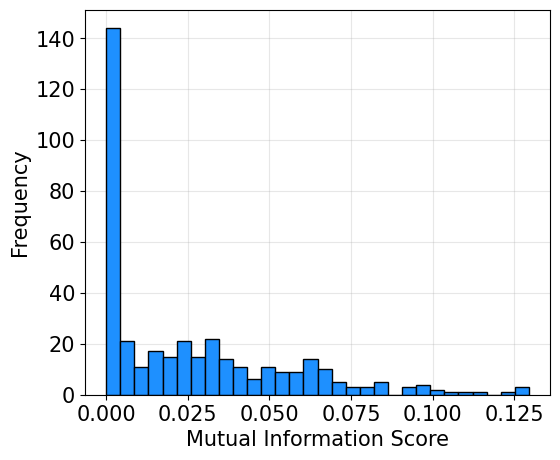

In [193]:
valz = []
for col, val in mutual_info.items():
    if col[0] != "o" and val != -1:
        valz.append(val)
        
plt.hist(valz, color="dodgerblue", edgecolor="k", bins=30)
plt.xlabel("Mutual Information Score")
plt.ylabel("Frequency")
plt.show()

In [ ]:
mutual_info = {}

for i, col in enumerate(df.columns):
    if col not in ["hhid", "community_code"]:
        X = {}
        for hhid in df.hhid:
            if hhid in num_changes:  
                val = list(df.loc[df.hhid==hhid][col])[0]
                X[hhid] = val if not np.isnan(val) else - 10

        sorted_keys = sorted(X.keys())
        X = np.array([X[k] for k in sorted_keys]).reshape(-1,1)
        y = np.array([num_changes[k] for k in sorted_keys])
        try:
            mutual_info[col] = mutual_info_regression(X,y)[0]
        except:
            mutual_info[col] = -1

    if (i % 10) == 0:
        print(f"Progress: {i/num_cols:.2f} ...")

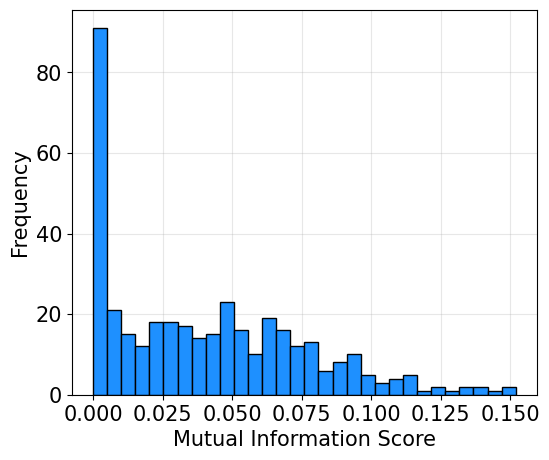

In [184]:
valz = []
for col, val in mutual_info.items():
    if col[0] != "o" and val != -1:
        valz.append(val)
        
plt.hist(valz, color="dodgerblue", edgecolor="k", bins=30)
plt.xlabel("Mutual Information Score")
plt.ylabel("Frequency")
plt.show()

In [159]:
k = sorted(mutual_info, key=lambda x: mutual_info[x], reverse=True)
k = [item for item in k if item[0] != "o"]

pairs = []
for item in k:
    pairs.append((item, mutual_info[item]))
    
pairs[:15]

[('j03_2_miscellaneous_expenses', 0.2422801942209829),
 ('j02_1_vehicle_expenses', 0.22404994210686602),
 ('r6_04_2_2', 0.19943450063543144),
 ('r6_03_1_3', 0.161805842015585),
 ('r7_11_1_3', 0.1418564365763988),
 ('r7_11_1_2', 0.13461671782986118),
 ('j03_2_family_events_expenses', 0.13055555555555576),
 ('r7_07_2_3', 0.12615182269547232),
 ('r7_06_2_3', 0.10387365663563619),
 ('job_farming', 0.09939711695271258),
 ('weight_food_drinks', 0.0916661736844584),
 ('s_06_3_2', 0.08231736077019924),
 ('value_food_other', 0.08024871898797814),
 ('j03_1_health_expenses', 0.07870370370370372),
 ('m01', 0.07748945845422206)]